<a href="https://colab.research.google.com/github/ayush-2405/Sudoku_Solver/blob/main/SudokuMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from models import *
from tensorflow.python.keras.models import Sequential, load_model
import imutils
import os
from skimage.segmentation import clear_border
from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
import torch, torchvision
from torchvision import transforms
import requests
from PIL import Image
from io import BytesIO
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import pandas as pd

T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [3]:
def find_board(image, display_steps=True):
    # Convert the input image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if display_steps:
        cv2_imshow(cv2.resize(gray_image, (360, 360)))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Apply Gaussian Blur to reduce noise and smoothen the image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 4)
    if display_steps:
        cv2_imshow(cv2.resize(blurred_image, (360, 360)))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Apply adaptive thresholding to detect edges and contours
    threshold_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )
    if display_steps:
        cv2_imshow(cv2.resize(threshold_image, (360, 360)))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    processed_image = threshold_image
    original_image_copy = image.copy()

    # Find contours in the thresholded image and sort them by size in descending order
    contours = cv2.findContours(processed_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Initialize the contour that corresponds to the Sudoku board outline
    sudoku_board_contour = None
    for contour in contours:
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx_polygon = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
        # If the approximated contour has four points, we assume we've found the Sudoku board outline
        if len(approx_polygon) == 4:
            sudoku_board_contour = approx_polygon
            board_location = approx_polygon
            break

    # Raise an exception if the Sudoku board contour is not found
    if sudoku_board_contour is None:
        raise Exception("Could not find Sudoku puzzle outline. Try debugging your thresholding and contour steps.")

    # Display the detected Sudoku board contour on the original image
    if display_steps:
        contour_output = original_image_copy.copy()
        cv2.drawContours(contour_output, [sudoku_board_contour], -1, (255, 0, 0), 2)
        cv2_imshow(cv2.resize(contour_output, (360, 360)))
        cv2.waitKey(0)

    # Perform a perspective transform to get a top-down view of the Sudoku board
    warped_color_image = four_point_transform(original_image_copy, sudoku_board_contour.reshape(4, 2))
    warped_grayscale_image = four_point_transform(processed_image, sudoku_board_contour.reshape(4, 2))

    # Display the warped grayscale image
    if display_steps:
        cv2_imshow(cv2.resize(warped_grayscale_image, (360, 360)))
        cv2.waitKey(0)

    return (warped_grayscale_image, warped_color_image, board_location)


In [26]:
def digit_extract(image, position, image_size, grid_dimensions, output_size, display=True):
    # Convert the input image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    processed_image = gray_image

    # Calculate the height of each cell in the grid
    cell_height = image_size[0] // grid_dimensions[0]
    # Calculate the width of each cell in the grid
    cell_width = image_size[1] // grid_dimensions[1]

    # Calculate the top boundary of the digit cell
    top_boundary = cell_height * position[0]
    # Calculate the bottom boundary of the digit cell
    bottom_boundary = top_boundary + cell_height
    # Calculate the left boundary of the digit cell
    left_boundary = cell_width * position[1]
    # Calculate the right boundary of the digit cell
    right_boundary = left_boundary + cell_width

    # Crop the digit cell from the processed image
    digit_cell = processed_image[top_boundary:bottom_boundary, left_boundary:right_boundary]

    # Apply OTSU thresholding with binary inversion
    digit_cell = cv2.threshold(digit_cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Clear objects connected to the image border
    digit_cell = clear_border(digit_cell)

    # Find the contours in the thresholded digit cell
    contours = cv2.findContours(digit_cell.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Handle different return types of findContours across OpenCV versions
    contours = imutils.grab_contours(contours)

    # Apply image masking if contours are found
    if len(contours) != 0:
        # Find the contour with the largest area
        largest_contour = max(contours, key=cv2.contourArea)
        # Create a mask of the same size as the digit cell
        mask = np.zeros(digit_cell.shape, dtype=np.uint8)
        # Draw the largest contour on the mask
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)
        # Apply the mask to the digit cell using bitwise AND
        digit_cell = cv2.bitwise_and(digit_cell, digit_cell, mask=mask)

    # Resize the digit cell to the desired output size
    digit_cell = cv2.resize(digit_cell, output_size)

    # Display the digit cell if required
    if display:
        cv2_imshow(digit_cell)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return digit_cell

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


In [6]:
model = sudokuCnn(output_classes=10)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('modelweights.pth', map_location=torch.device('cpu')))
model.to(device)

sudokuCnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
def predict(model,x):
    device = torch.device("cpu")
    model.eval()
    with torch.no_grad():
      x.to(device)
      scores = model(x)
      prediction = scores.argmax(1)

    return prediction

In [31]:
def digit_reader(model, device, image,img_size,grid_size,show=True):
  sudoku_array = []
  img = cv2.resize(image,img_size)
  cv2_imshow(img)
  for i in range(grid_size[0]):
    for j in range(grid_size[1]):
      digit = digit_extract(img,(i,j),img_size,grid_size,(28,28),display=display)
      digit = torch.tensor(digit)
      blank_threshold = (torch.sum(digit))
      if blank_threshold <=(255*15):
        sudoku_array.append(0)
        if (show==True):
          print(torch.tensor([0]))
      else:
        digit = digit.reshape((1,1,28,28)).float()

        model.eval()
        model = model.to(device = device)
        digit = digit.to(device)
        digit_read = predict(model,digit)

        digit_final = torch.mode(digit_read)
        if (show ==True):
          print(digit_read)
          sudoku_array.append(digit_final[0])

  sudoku_array = np.array(sudoku_array)
  return (sudoku_array)

# **SUDOKU_SOLVER**

In [10]:
def find_empty(board):
    """Checks where there is an empty or unsolved block."""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col
    return None

def isValid(board, num, pos):
    """Check if placing the number num at position pos is valid."""
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check submatrix(3 x 3)
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x * 3 + 3):
            if board[i][j] == num and (i, j) != pos:
                return False

    return True

def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1, 10):
        if isValid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True

            board[row][col] = 0

    return False

def get_board(bo):
    if solve(bo):
        print(bo)
        return bo
    else:
        raise ValueError("The Sudoku puzzle is unsolvable")


In [11]:
# def displayNumbers(img, numbers, color=(0, 255, 0)):
#   W = int(img.shape[1]/9)
#   H = int(img.shape[0]/9)
#   for i in range (9):
#     for j in range (9):
#       if numbers[(j*9)+i] !=0:
#         cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)),int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 1, color, 2, cv2.LINE_AA)
#   return img

In [42]:
def display_numbers(image, number_grid, color=(0, 255, 0)):
    # Calculate the width of each cell in the Sudoku grid
    cell_width = int(image.shape[1] / 9)
    # Calculate the height of each cell in the Sudoku grid
    cell_height = int(image.shape[0] / 9)

    # Iterate through each cell in the 9x9 grid
    for row in range(9):
        for col in range(9):
            # Check if the current cell contains a non-zero number
            if number_grid[(col * 9) + row] != 0:
                # Calculate the position where the number should be displayed
                x_position = col * cell_width + int(cell_width / 2) - int(cell_width / 4)
                y_position = int((row + 0.7) * cell_height)
                # Put the number on the image at the calculated position
                cv2.putText(image, str(number_grid[(col * 9) + row]),
                            (x_position, y_position),
                            cv2.FONT_HERSHEY_COMPLEX, 1, color, 2, cv2.LINE_AA)

    return image

# **1st Sudoku Board**

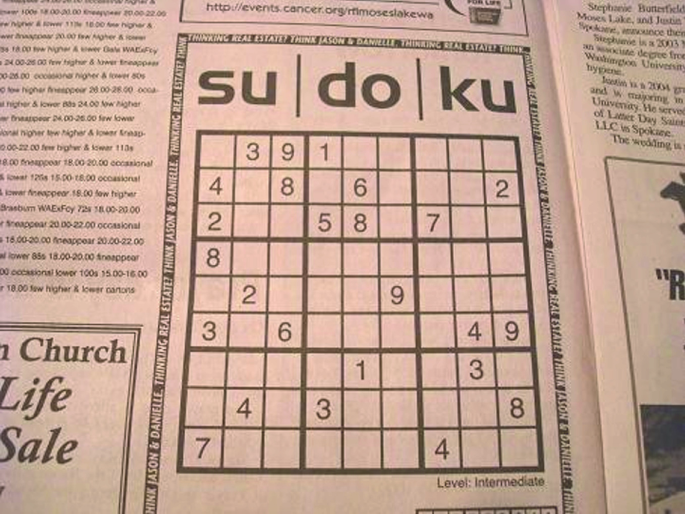

In [12]:
img = cv2.imread('/content/sudoku.png')
original_pic=(img)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

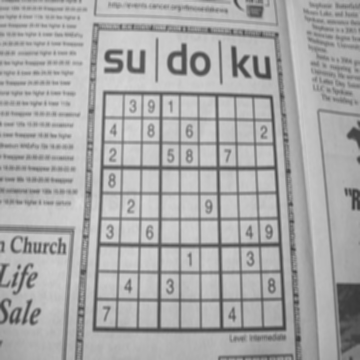

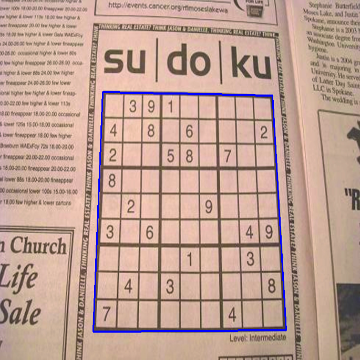

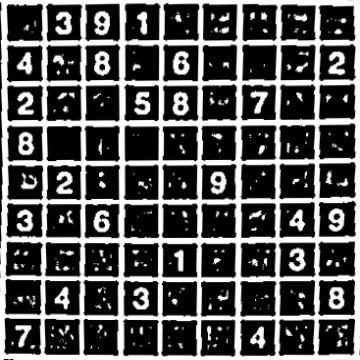

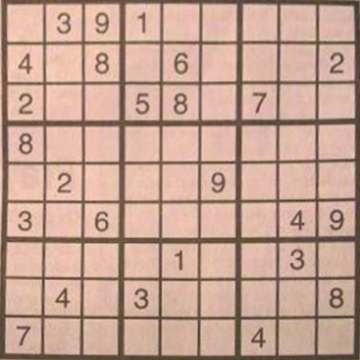

In [13]:
board= find_board(img)
cv2_imshow(cv2.resize(board[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

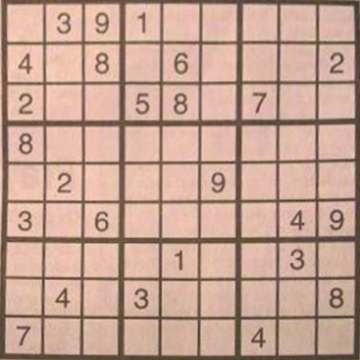

tensor([0])


tensor([3])


tensor([9])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([2])


tensor([0])


tensor([0])


tensor([5])


tensor([8])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([0])


In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted=digit_reader(model, device, board[1],(360,360),(9,9),show=True)
sudoku_array=unsolved_predicted.reshape(9,9)

In [22]:
unsolved_predicted

array([0, 3, 9, 1, 0, 0, 0, 0, 0, 4, 0, 8, 0, 6, 0, 0, 0, 2, 2, 0, 0, 5,
       8, 0, 7, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0,
       0, 3, 0, 6, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 4, 0,
       3, 0, 0, 0, 0, 8, 7, 0, 0, 0, 0, 0, 4, 0, 0])

In [18]:
sudoku_array

array([[0, 3, 9, 1, 0, 0, 0, 0, 0],
       [4, 0, 8, 0, 6, 0, 0, 0, 2],
       [2, 0, 0, 5, 8, 0, 7, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 9, 0, 0, 0],
       [3, 0, 6, 0, 0, 0, 0, 4, 9],
       [0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 4, 0, 3, 0, 0, 0, 0, 8],
       [7, 0, 0, 0, 0, 0, 4, 0, 0]])

In [19]:
grid=np.array(sudoku_array)
grid=grid.reshape(9,9)
grid

array([[0, 3, 9, 1, 0, 0, 0, 0, 0],
       [4, 0, 8, 0, 6, 0, 0, 0, 2],
       [2, 0, 0, 5, 8, 0, 7, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 9, 0, 0, 0],
       [3, 0, 6, 0, 0, 0, 0, 4, 9],
       [0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 4, 0, 3, 0, 0, 0, 0, 8],
       [7, 0, 0, 0, 0, 0, 4, 0, 0]])

In [20]:
output=get_board(grid)


[[5 3 9 1 7 2 6 8 4]
 [4 7 8 9 6 3 1 5 2]
 [2 6 1 5 8 4 7 9 3]
 [8 9 7 6 4 5 3 2 1]
 [1 2 4 8 3 9 5 7 6]
 [3 5 6 7 2 1 8 4 9]
 [9 8 5 4 1 6 2 3 7]
 [6 4 2 3 5 7 9 1 8]
 [7 1 3 2 9 8 4 6 5]]


In [23]:
binArr = np.where(np.array(unsolved_predicted)>0, 0, 1)
print(binArr)
# get only solved numbers for the solved board
flat_solved_board_nums = output.flatten()*binArr
# create a mask
mask = np.zeros_like(board[1])
solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
cv2_imshow(solved_board_mask)

[1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1
 1 1 1 1 0 1 1]


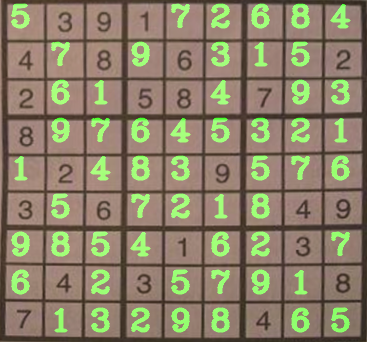

In [24]:
try:
  combined = cv2.addWeighted(board[1], 0.7, solved_board_mask, 1, 0)
  cv2_imshow(combined)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **2nd Sudoku Board**

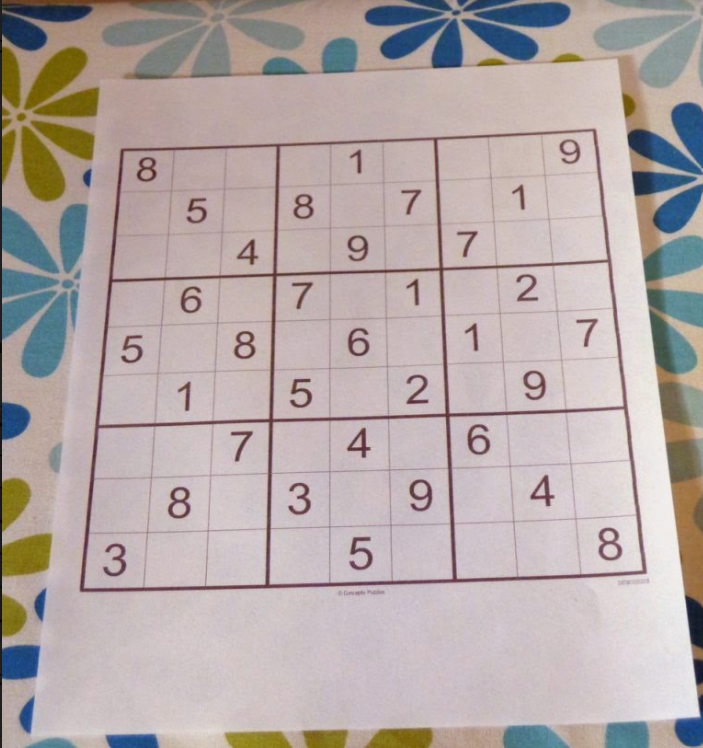

In [25]:
img2 = cv2.imread('/content/sudoku1.png')
original_pic2=(img2)
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

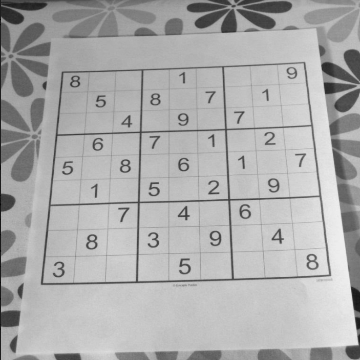

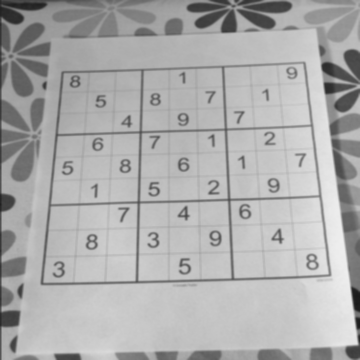

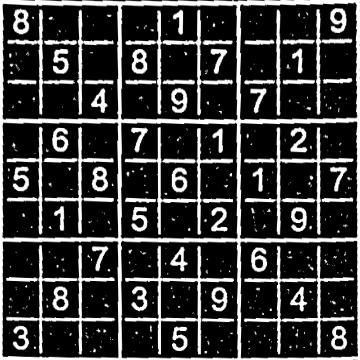

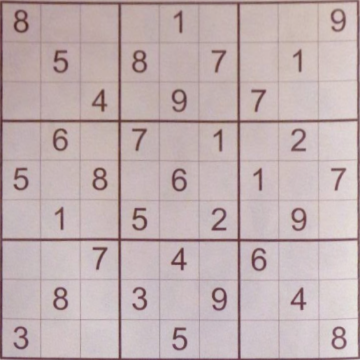

In [27]:
board2= find_board(img2)
cv2_imshow(cv2.resize(board2[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

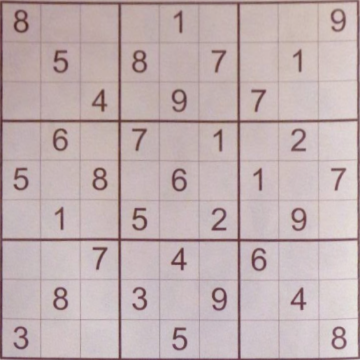

tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([0])


tensor([5])


tensor([0])


tensor([8])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([9])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([2])


tensor([0])


tensor([5])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([1])


tensor([0])


tensor([7])


tensor([0])


tensor([1])


tensor([0])


tensor([5])


tensor([0])


tensor([2])


tensor([0])


tensor([9])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([4])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([3])


tensor([0])


tensor([9])


tensor([0])


tensor([4])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


In [37]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted2=digit_reader(model, device, board2[1],(360,360),(9,9),show=True)
sudoku_array2=unsolved_predicted2.reshape(9,9)

In [38]:
unsolved_predicted2

array([8, 0, 0, 0, 1, 0, 0, 0, 9, 0, 5, 0, 8, 0, 7, 0, 1, 0, 0, 0, 4, 0,
       9, 0, 7, 0, 0, 0, 6, 0, 7, 0, 1, 0, 2, 0, 5, 0, 8, 0, 6, 0, 1, 0,
       7, 0, 1, 0, 5, 0, 2, 0, 9, 0, 0, 0, 7, 0, 4, 0, 6, 0, 0, 0, 8, 0,
       3, 0, 9, 0, 4, 0, 3, 0, 0, 0, 5, 0, 0, 0, 8])

In [34]:
sudoku_array2

array([[8, 0, 0, 0, 1, 0, 0, 0, 9],
       [0, 5, 0, 8, 0, 7, 0, 1, 0],
       [0, 0, 4, 0, 9, 0, 7, 0, 0],
       [0, 6, 0, 7, 0, 1, 0, 2, 0],
       [5, 0, 8, 0, 6, 0, 1, 0, 7],
       [0, 1, 0, 5, 0, 2, 0, 9, 0],
       [0, 0, 7, 0, 4, 0, 6, 0, 0],
       [0, 8, 0, 3, 0, 9, 0, 4, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 8]])

In [35]:
grid2=np.array(sudoku_array2)
grid2=grid2.reshape(9,9)
grid2

array([[8, 0, 0, 0, 1, 0, 0, 0, 9],
       [0, 5, 0, 8, 0, 7, 0, 1, 0],
       [0, 0, 4, 0, 9, 0, 7, 0, 0],
       [0, 6, 0, 7, 0, 1, 0, 2, 0],
       [5, 0, 8, 0, 6, 0, 1, 0, 7],
       [0, 1, 0, 5, 0, 2, 0, 9, 0],
       [0, 0, 7, 0, 4, 0, 6, 0, 0],
       [0, 8, 0, 3, 0, 9, 0, 4, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 8]])

In [36]:
output2=get_board(sudoku_array2)


[[8 7 2 4 1 3 5 6 9]
 [9 5 6 8 2 7 3 1 4]
 [1 3 4 6 9 5 7 8 2]
 [4 6 9 7 3 1 8 2 5]
 [5 2 8 9 6 4 1 3 7]
 [7 1 3 5 8 2 4 9 6]
 [2 9 7 1 4 8 6 5 3]
 [6 8 5 3 7 9 2 4 1]
 [3 4 1 2 5 6 9 7 8]]


[0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1
 1 1 0 1 1 1 0]


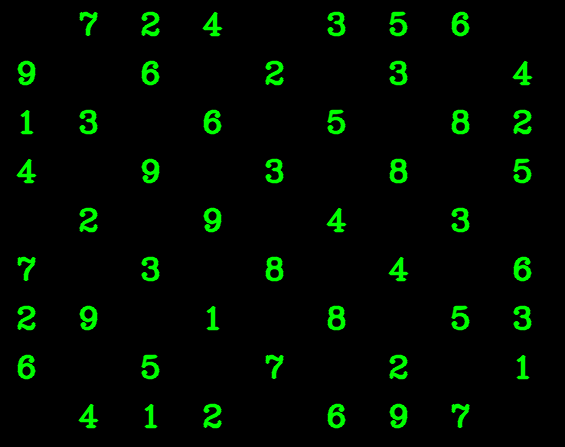

In [39]:
binArr2 = np.where(np.array(unsolved_predicted2)>0, 0, 1)
print(binArr2)
# get only solved numbers for the solved board
flat_solved_board_nums2 = output2.flatten()*binArr2
# create a mask
mask2 = np.zeros_like(board2[1])
solved_board_mask2= displayNumbers(mask2, flat_solved_board_nums2)
cv2_imshow(solved_board_mask2)

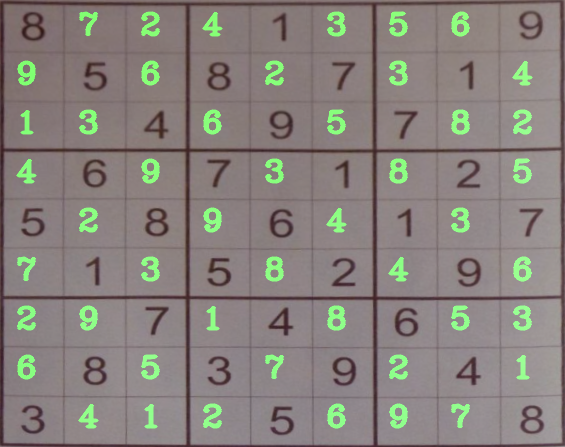

In [40]:
try:
  combined2 = cv2.addWeighted(board2[1], 0.7, solved_board_mask2, 1, 0)
  cv2_imshow(combined2)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **3rd Sudoku Board**

In [43]:
img3 = cv2.imread('/content/sudoku3.png')
original_pic3=(img3)
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

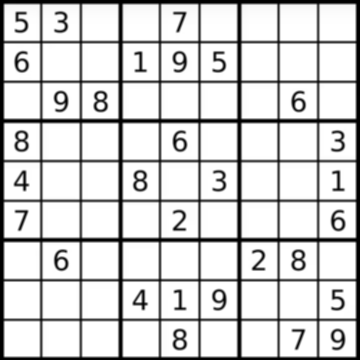

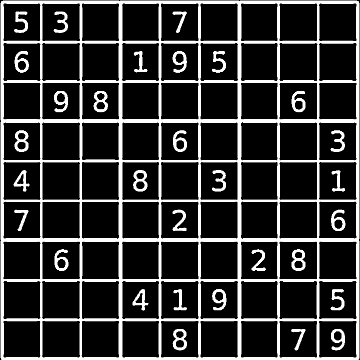

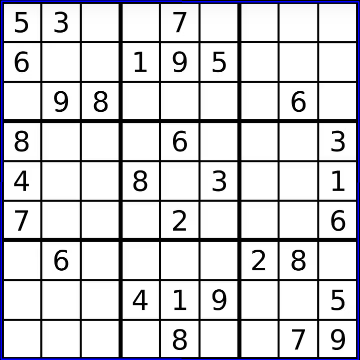

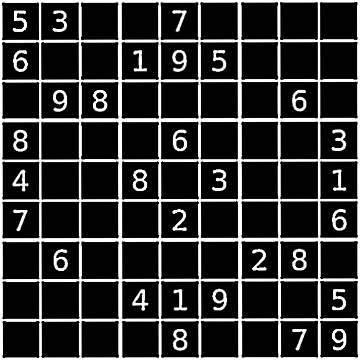

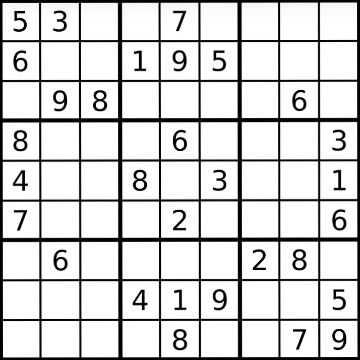

In [44]:
board3= find_board(img3)
cv2_imshow(cv2.resize(board3[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

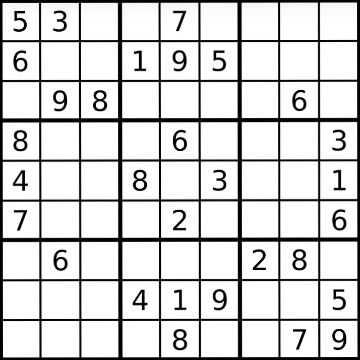

tensor([5])


tensor([3])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([1])


tensor([9])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([4])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([1])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([0])


tensor([0])


tensor([0])


tensor([6])


tensor([0])


tensor([6])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([2])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([4])


tensor([1])


tensor([9])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([7])


tensor([9])


In [50]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted3=digit_reader(model, device, board3[1],(360,360),(9,9),show=True)
sudoku_array3=unsolved_predicted3.reshape(9,9)

In [51]:
unsolved_predicted3

array([5, 3, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 1, 9, 5, 0, 0, 0, 0, 9, 8, 0,
       0, 0, 0, 6, 0, 8, 0, 0, 0, 6, 0, 0, 0, 3, 4, 0, 0, 8, 0, 3, 0, 0,
       1, 7, 0, 0, 0, 2, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0,
       4, 1, 9, 0, 0, 5, 0, 0, 0, 0, 8, 0, 0, 7, 9])

In [47]:
grid3=np.array(sudoku_array3)
grid3=grid3.reshape(9,9)
grid3

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [48]:
sudoku_array3

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [49]:
output3=get_board(sudoku_array3)

[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]


[0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1
 1 1 0 1 1 0 0]


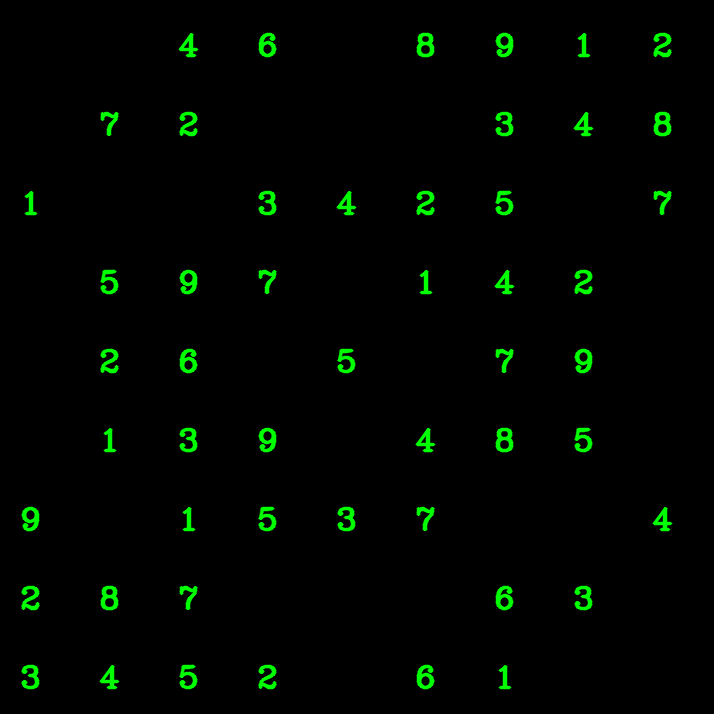

In [52]:
binArr3 = np.where(np.array(unsolved_predicted3)>0, 0, 1)
print(binArr3)
# get only solved numbers for the solved board
flat_solved_board_nums3 = output3.flatten()*binArr3
# create a mask
mask3 = np.zeros_like(board3[1])
solved_board_mask3= displayNumbers(mask3, flat_solved_board_nums3)
cv2_imshow(solved_board_mask3)

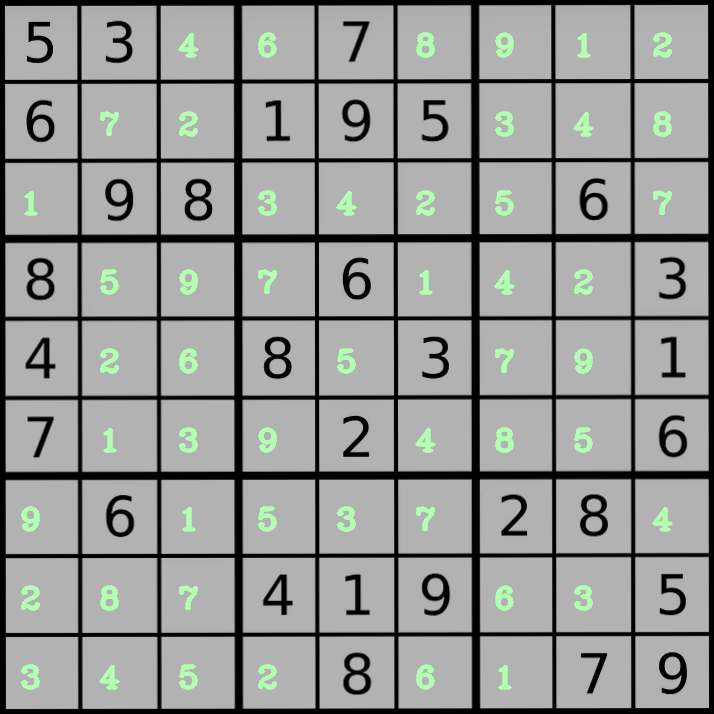

In [53]:
try:
  combined3 = cv2.addWeighted(board3[1], 0.7, solved_board_mask3, 1, 0)
  cv2_imshow(combined3)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")

# **4th Sudoku Board**

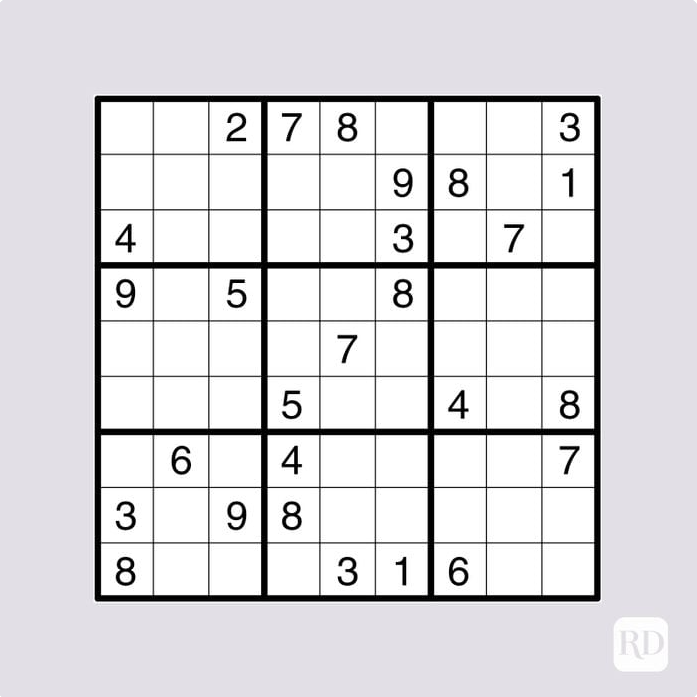

In [54]:
img4 = cv2.imread('/content/sudoku4.png')
original_pic4=(img4)
cv2_imshow(img4)
cv2.waitKey(0)
cv2.destroyAllWindows()

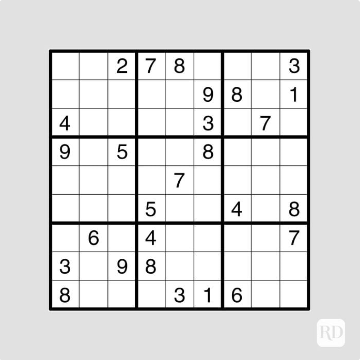

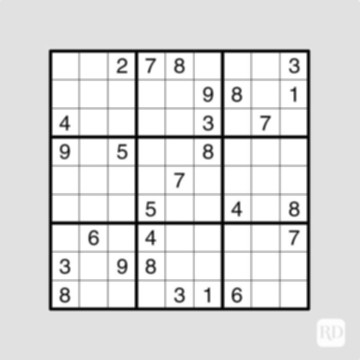

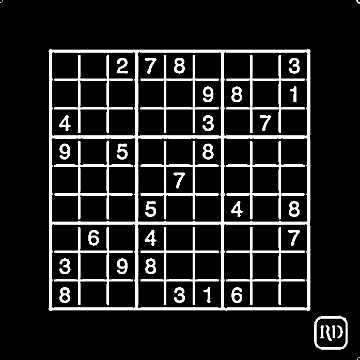

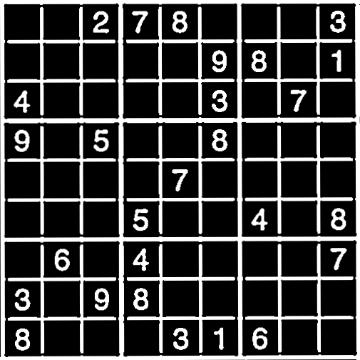

In [56]:
board4= find_board(img4)
cv2_imshow(cv2.resize(board4[1],(360,360)))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [61]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
unsolved_predicted4=digit_reader(model, device, board4[1],(360,360),(9,9),show=True)
sudoku_array4=unsolved_predicted4.reshape(9,9)

tensor([0])


tensor([0])


tensor([2])


tensor([7])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([1])


tensor([4])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([0])


tensor([7])


tensor([0])


tensor([9])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([5])


tensor([0])


tensor([0])


tensor([4])


tensor([0])


tensor([8])


tensor([0])


tensor([6])


tensor([0])


tensor([4])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([7])


tensor([3])


tensor([0])


tensor([9])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([0])


tensor([8])


tensor([0])


tensor([0])


tensor([0])


tensor([3])


tensor([1])


tensor([6])


tensor([0])


tensor([0])


In [62]:
unsolved_predicted4

array([0, 0, 2, 7, 8, 0, 0, 0, 3, 0, 0, 0, 0, 0, 9, 8, 0, 1, 4, 0, 0, 0,
       0, 3, 0, 7, 0, 9, 0, 5, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 4, 0, 8, 0, 6, 0, 4, 0, 0, 0, 0, 7, 3, 0, 9,
       8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 3, 1, 6, 0, 0])

In [59]:
sudoku_array4

array([[0, 0, 2, 7, 8, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 9, 8, 0, 1],
       [4, 0, 0, 0, 0, 3, 0, 7, 0],
       [9, 0, 5, 0, 0, 8, 0, 0, 0],
       [0, 0, 0, 0, 7, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 4, 0, 8],
       [0, 6, 0, 4, 0, 0, 0, 0, 7],
       [3, 0, 9, 8, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 3, 1, 6, 0, 0]])

In [60]:
output4=get_board(sudoku_array4)

[[1 9 2 7 8 4 5 6 3]
 [5 3 7 6 2 9 8 4 1]
 [4 8 6 1 5 3 9 7 2]
 [9 1 5 3 4 8 7 2 6]
 [6 4 8 9 7 2 1 3 5]
 [7 2 3 5 1 6 4 9 8]
 [2 6 1 4 9 5 3 8 7]
 [3 5 9 8 6 7 2 1 4]
 [8 7 4 2 3 1 6 5 9]]


In [63]:
binArr4 = np.where(np.array(unsolved_predicted4)>0, 0, 1)
print(binArr4)
# get only solved numbers for the solved board
flat_solved_board_nums4 = output4.flatten()*binArr4
# create a mask
mask4 = np.zeros_like(board4[1])
solved_board_mask4 = displayNumbers(mask4, flat_solved_board_nums4)
cv2_imshow(solved_board_mask4)

[1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1
 1 1 0 0 0 1 1]


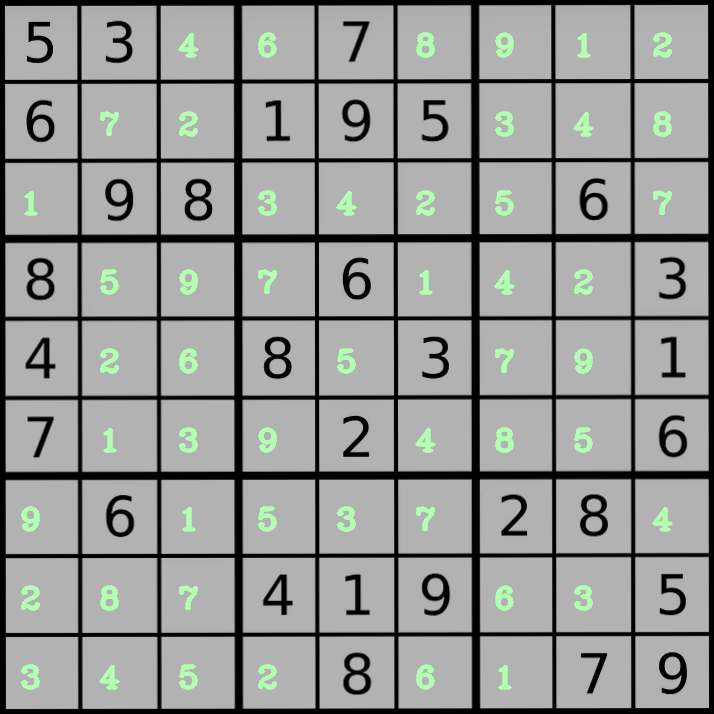

In [64]:
try:
  combined3 = cv2.addWeighted(board3[1], 0.7, solved_board_mask3, 1, 0)
  cv2_imshow(combined3)
  cv2.waitKey(0)
except:
  print("Solution doesn't exist or Model misread digits.")